In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tensorflow.keras.regularizers import l2




In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

train_dir = '/kaggle/input/pcos-detection-using-ultrasound-images/data/train'
test_dir = '/kaggle/input/pcos-detection-using-ultrasound-images/data/test'

img_size = (224, 224) 
batch_size = 32



In [ ]:

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  
        return True
    except Exception:
        print(f"Skipping corrupted image: {file_path}")
        return False

def custom_generator(directory, datagen, class_mode='binary'):
    valid_filenames = []
    valid_classes = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            if is_valid_image(file_path):
                valid_filenames.append(file_path)
                valid_classes.append(class_name)

    return datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': valid_filenames, 'class': valid_classes}),
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode
    )


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = custom_generator(train_dir, train_datagen)
test_generator = custom_generator(test_dir, test_datagen)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_layer)



In [ ]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_pcos_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)



Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 437s 7s/step - accuracy: 0.9677 - loss: 0.3501 - val_accuracy: 0.9984 - val_loss: 0.2578
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 409s 7s/step - accuracy: 0.9933 - loss: 0.2834 - val_accuracy: 0.9995 - val_loss: 0.2476
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 419s 7s/step - accuracy: 0.9958 - loss: 0.2649 - val_accuracy: 1.0000 - val_loss: 0.2409
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 419s 7s/step - accuracy: 0.9975 - loss: 0.2548 - val_accuracy: 1.0000 - val_loss: 0.2354
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 412s 7s/step - accuracy: 1.0000 - loss: 0.2467 - val_accuracy: 1.0000 - val_loss: 0.2309
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 409s 7s/step - accuracy: 0.9981 - loss: 0.2444 - val_accuracy: 1.0000 - val_loss: 0.2273
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 409s 7s/step - accuracy: 0.9983 - loss: 0.2405 - val_accuracy: 1.0000 - val_loss: 0.2249
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 425s 7s/step - accuracy: 0.9986 - loss: 0.2370 - val_accuracy: 1.0000 - v

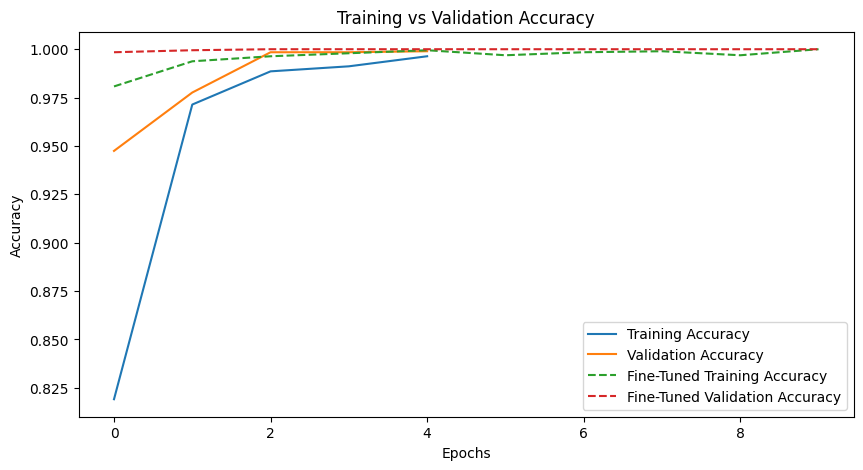

✅ Best model saved as 'best_pcos_model.h5'.


In [ ]:

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
    
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tuned Training Accuracy', linestyle='dashed')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tuned Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

print("✅ Best model saved as 'best_pcos_model.h5'.")
